# **Statistical Evaluation**

This Notebook performs the statistical evaluation of our synthetic product reviews:

* Statistical tendencies (Zipf's law)
* Linguistic features (review length, type-token ratio/TTR, verb and noun usage using POS tagging, readability scores)
* MAUVE
* Human evaluation (inter-rater reliability and PERMANOVA)

Note that this Notebook has been run in Kaggle and some code, such as the loading of the data, will have to be changed if you run this Notebook outside of Kaggle.

## Preparation

In [1]:
# Install packages if you have not already (mainly for Kaggle)
!pip install stanza
!pip install textstat
!pip install mauve-text
!pip install krippendorff
!pip install scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 12.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 60.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 62.2 MB/s eta 0:00:0000:010:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=2504426 sha256=623f3121c60d6a8df91a4f5d62ccd8b309bb659daee1e96cf6b1d72a97a3f8bb
  Stored in directory:

In [2]:
# Import the necessary packages
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import scipy.stats as stats
import nltk
from nltk.corpus import stopwords
from scipy.special import zetac
from scipy.stats import chi2
from scipy.optimize import minimize
import stanza
import textstat
import mauve
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
from transformers import set_seed

# Download additional files for NLTK and stanza
nltk.download('punkt')
nltk.download('stopwords')
stanza.download('en')

# Set seed for reproducible and consistent results
set_seed(42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-08-27 10:51:55.794715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:51:55.794828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:51:55.931614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load and prepare the data

### Real product reviews

In [3]:
# Load real product reviews
real_reviews = pd.read_parquet('/kaggle/input/real-reviews/preprocessed_reviews.parquet')

# Randomly sample 10,000 reviews
real_reviews = real_reviews.sample(n=10000, random_state=42)

# Save the random sample for later (for sentiment analysis)
real_reviews.to_csv('real_reviews_10k_sample.csv', index=False)

# Tokenize, clean, and turn text into array
revs_real = real_reviews['text'].copy()

words_list_real = []
words_lists_real = []

for rev in revs_real:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_real.extend(tokens) # Needed for computing statistical tendencies and TTR
    words_lists_real.append(tokens) # Needed for computing average length and SD of length

# Concatenate reviews (needed for POS tagging and computing readability scores)
full_text_real = " ".join(real_reviews['text'].dropna().tolist())

### GPT-2 generated product reviews

In [4]:
# Load GPT-2 generated product reviews
gpt2_reviews = pd.read_csv('/kaggle/input/gpt-2-reviews/gpt-2_synthetic_reviews.csv')

# Tokenize, clean, and turn text into array
revs_gpt2 = gpt2_reviews['Generated Review'].copy()

words_list_gpt2 = []
words_lists_gpt2 = []

for rev in revs_gpt2:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_gpt2.extend(tokens) # Needed for computing statistical tendencies and TTR
    words_lists_gpt2.append(tokens) # Needed for computing average length and SD of length

# Concatenate reviews (needed for POS tagging and computing readability scores)
full_text_gpt2 = " ".join(gpt2_reviews['Generated Review'].dropna().tolist())

### LLaMA 3 generated product reviews

In [5]:
# Load LLaMA 3 generated product reviews
llama3_reviews = pd.read_csv('/kaggle/input/llama-3-reviews/llama-3_synthetic_reviews_split.csv')

# Tokenize, clean, and turn text into array
revs_llama3 = llama3_reviews['Generated Review'].copy()

words_list_llama3 = []
words_lists_llama3 = []

for rev in revs_llama3:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_llama3.extend(tokens) # Needed for computing statistical tendencies and TTR
    words_lists_llama3.append(tokens) # Needed for computing average length and SD of length

# Concatenate reviews (needed for POS tagging and computing readability scores)
full_text_llama3 = " ".join(llama3_reviews['Generated Review'].dropna().tolist())

## Statistical tendencies

### Log-log plot of of word rank vs. word frequency

In [6]:
# Define function for calculating frequencies and ranks and plotting a log-log graph
def create_loglogplot(words_list):
    # Count word frequencies
    word_counts = Counter(words_list)

    # Sort the word frequencies
    frequencies = np.array(sorted(word_counts.values(), reverse=True))

    # Generate ranks
    ranks = np.arange(1, len(frequencies) + 1)

    # Create the log-log plot
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker=".", linestyle='none', label="Data")
    # Add the Zipf's law line (red line)
    zipf_frequencies = frequencies[0] / ranks
    plt.loglog(ranks, zipf_frequencies, color='red', linestyle='--', label="Zipf's Law")
    # Title is dependent on function input
    if words_list == words_list_real:
        plt.title('Real Reviews', weight='bold', fontsize=20)
    elif words_list == words_list_gpt2:
        plt.title('GPT-2 Reviews', weight='bold', fontsize=20)
    else:
        plt.title('LLaMA 3 Reviews', weight='bold', fontsize=20)
    plt.xlabel("Word Rank (log scale)", weight='bold', fontsize=17)
    plt.ylabel("Word Frequency (log scale)", weight='bold', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=16)
    # Save file name is dependent on function input
    if words_list == words_list_real:
        plt.savefig('loglogplot_real_revs.pdf', format='pdf', dpi=1500)
    elif words_list == words_list_gpt2:
        plt.savefig('loglogplot_gpt2_revs.pdf', format='pdf', dpi=1500)
    else:
        plt.savefig('loglogplot_llama3_revs.pdf', format='pdf', dpi=1500)
    plt.show()

    # Return frequencies and ranks for later calculations
    return frequencies, ranks

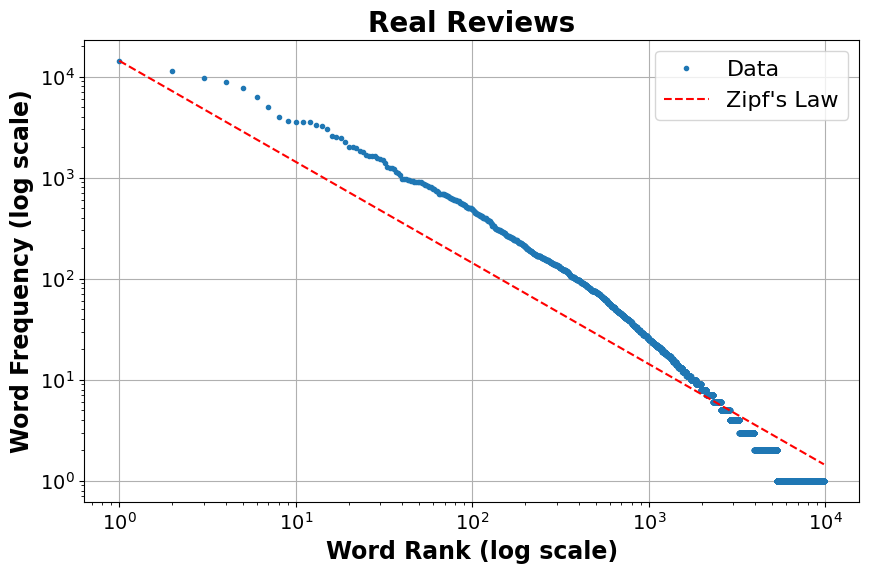

In [7]:
# Log-log plot for the real product reviews
frequencies_real, ranks_real = create_loglogplot(words_list_real)

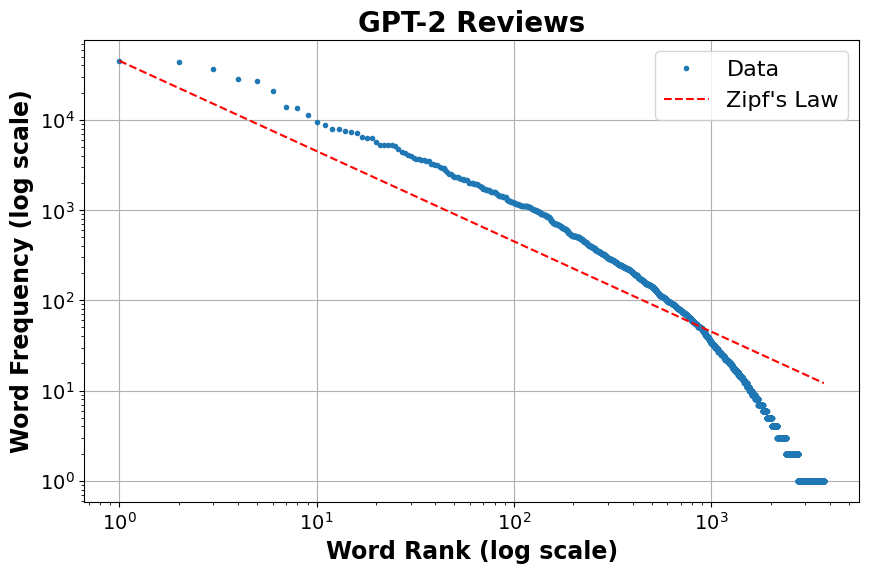

In [8]:
# Log-log plot for the GPT-2 generated product reviews
frequencies_gpt2, ranks_gpt2 = create_loglogplot(words_list_gpt2)

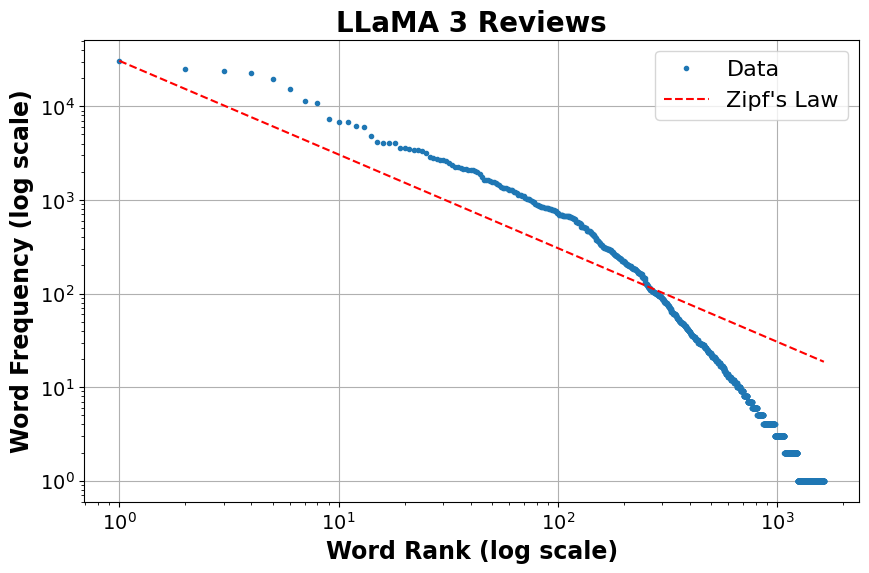

In [9]:
# Log-log plot for the LLaMA 3 generated product reviews
frequencies_llama3, ranks_llama3 = create_loglogplot(words_list_llama3)

### Likelihood ratio test

In [10]:
# Define a function for testing Zipf's law using a likelihood ratio test
def LRT(frequencies, ranks):
    
    # Define a function for the Zipf probability distribution
    def zipf_pmf(rank, s, N):
        # Proper normalization for Zipf distribution using generalized harmonic number
        harmonic_number = np.sum(1 / np.arange(1, N+1) ** s)
        return (1 / rank ** s) / harmonic_number

    # Define a function to compute the log-likelihood for Zipf's law
    def log_likelihood_zipf(frequencies, ranks, s):
        N = len(ranks)
        pmf_values = np.array([zipf_pmf(rank, s, N) for rank in ranks])
        
        # Avoid log(0) by ensuring all probabilities are non-zero
        pmf_values[pmf_values == 0] = np.finfo(float).eps # Very small value instead of 0
        
        log_likelihood = np.sum(frequencies * np.log(pmf_values))
        return log_likelihood

    # Define a function for the alternative model's probability distribution (e.g., uniform)
    def uniform_pmf(rank, N):
        return 1 / N

    # Define a function to compute the log-likelihood for the alternative model
    def log_likelihood_uniform(frequencies, ranks):
        N = len(ranks)
        pmf_values = np.array([uniform_pmf(rank, N) for rank in ranks])
        
        # Avoid log(0)
        pmf_values[pmf_values == 0] = np.finfo(float).eps
        
        log_likelihood = np.sum(frequencies * np.log(pmf_values))
        return log_likelihood

    # Estimate the parameter s for Zipf's law using maximum likelihood estimation (MLE)

    # Negative log-likelihood function for Zipf's law
    def neg_log_likelihood_zipf(s, frequencies, ranks):
        return -log_likelihood_zipf(frequencies, ranks, s)

    # Initial guess for s
    initial_s = 1.0

    # Perform MLE to estimate the best s
    result = minimize(neg_log_likelihood_zipf, initial_s, args=(frequencies, ranks), bounds=[(0.001, 5)], method='L-BFGS-B')
    best_s = result.x[0]

    # Calculate the log-likelihoods for both models
    log_likelihood_zipf_model = log_likelihood_zipf(frequencies, ranks, best_s)
    log_likelihood_uniform_model = log_likelihood_uniform(frequencies, ranks)

    # Compute the likelihood ratio test statistic
    likelihood_ratio_statistic = -2 * (log_likelihood_uniform_model - log_likelihood_zipf_model)

    # Perform chi-square test to get the p-value (df=1, since we only estimate s for Zipf's law)
    p_value = chi2.sf(likelihood_ratio_statistic, df=1)

    # Print results
    print(f"Best Zipf exponent s: {best_s}")
    print(f"Likelihood Ratio Statistic: {likelihood_ratio_statistic}")
    print(f"P-value: {p_value:.10f}")

In [11]:
# LRT for GPT-2 generated product reviews
LRT(frequencies_gpt2, ranks_gpt2)

Best Zipf exponent s: 0.001
Likelihood Ratio Statistic: 5661.325395904481
P-value: 0.0000000000


In [12]:
# LRT for LLaMA 3 generated product reviews
LRT(frequencies_llama3, ranks_llama3)

Best Zipf exponent s: 0.001
Likelihood Ratio Statistic: 2939.246404823847
P-value: 0.0000000000


## Linguistic features

In [13]:
# Initialize the Stanza pipeline for English language
nlp = stanza.Pipeline('en', processors='tokenize,pos')

# Define a function for analyzing the linguistic features of the data
def compute_linguistic_features(words_list, words_lists, full_text):

    # Function to calculate average length and standard deviation of review lengths
    def calculate_length_stats(words_lists):
        lengths = [len(rev) for rev in words_lists]
        avg_length = np.average(lengths)
        std_length = np.std(lengths)
        return avg_length, std_length

    # Function to calculate Type-Token Ratio (TTR)
    def calculate_ttr(words_list):
        types = set(words_list)  # Unique words
        ttr = len(types) / len(words_list) if len(words_list) > 0 else 0
        return ttr

    # Function to calculate percentage of nouns and verbs in a corpus
    def calculate_pos_percentage(full_text):
        # POS tagging
        doc = nlp(full_text)
        
        # Initialize counters
        total_words = 0
        noun_count = 0
        verb_count = 0

        # Count the number of nouns and verbs
        for sentence in doc.sentences:
            for word in sentence.words:
                if word.upos == 'PUNCT':
                    continue
                total_words += 1
                if word.upos == 'NOUN':
                    noun_count += 1
                elif word.upos == 'VERB':
                    verb_count += 1

        # Calculate the percentage of nouns and verbs
        noun_percentage = (noun_count / total_words) * 100 if total_words > 0 else 0
        verb_percentage = (verb_count / total_words) * 100 if total_words > 0 else 0
        return noun_percentage, verb_percentage

    # Function to calculate readability scores
    def calculate_readability(full_text):
        flesch_score = textstat.flesch_reading_ease(full_text)
        dale_chall_score = textstat.dale_chall_readability_score(full_text)
        return flesch_score, dale_chall_score

    # Calculate all the metrics
    avg_length, std_length = calculate_length_stats(words_lists)
    ttr = calculate_ttr(words_list)
    noun_percentage, verb_percentage = calculate_pos_percentage(full_text)
    flesch_score, dale_chall_score = calculate_readability(full_text)

    # Print all results
    print(f"Average length of reviews: {avg_length:.4f}")
    print(f"Standard deviation of review lengths: {std_length:.4f}")
    print(f"TTR: {ttr:.4f}")
    print(f"Percentage of nouns: {noun_percentage:.4f}%")
    print(f"Percentage of verbs: {verb_percentage:.4f}%")
    print(f"Flesch Reading Ease Score: {flesch_score:.4f}")
    print(f"Dale-Chall Readability Score: {dale_chall_score:.4f}")

In [14]:
# Linguistic features of real product reviews
print('Real reviews results: \n---------------------')
compute_linguistic_features(words_list_real, words_lists_real, full_text_real)

Real reviews results: 
---------------------
Average length of reviews: 29.2954
Standard deviation of review lengths: 31.3627
TTR: 0.0335
Percentage of nouns: 17.2719%
Percentage of verbs: 13.1710%
Flesch Reading Ease Score: 84.3700
Dale-Chall Readability Score: 1.0800


In [15]:
# Linguistic features of GPT-2 generated product reviews
print('GPT-2 reviews results: \n----------------------')
compute_linguistic_features(words_list_gpt2, words_lists_gpt2, full_text_gpt2)

GPT-2 reviews results: 
----------------------
Average length of reviews: 73.2916
Standard deviation of review lengths: 29.8700
TTR: 0.0051
Percentage of nouns: 15.0922%
Percentage of verbs: 10.9775%
Flesch Reading Ease Score: 93.0300
Dale-Chall Readability Score: 0.6600


In [16]:
# Linguistic features of LLaMA 3 generated product reviews
print('LLaMA 3 reviews results: \n------------------------')
compute_linguistic_features(words_list_llama3, words_lists_llama3, full_text_llama3)

LLaMA 3 reviews results: 
------------------------
Average length of reviews: 41.3028
Standard deviation of review lengths: 9.0728
TTR: 0.0040
Percentage of nouns: 17.4589%
Percentage of verbs: 10.3533%
Flesch Reading Ease Score: 77.3300
Dale-Chall Readability Score: 0.5800


## MAUVE

In [17]:
# Compute MAUVE score for GPT-2 generated reviews vs real reviews
mauve_gpt2 = mauve.compute_mauve(
    p_text=revs_real.tolist(),
    q_text=revs_gpt2.tolist(),
    mauve_scaling_factor=1.0, # Hyperparameter (default is 5.0)
    num_buckets=100, # Size of the histogram for P and Q
    kmeans_max_iter=1000, # Number of k-means iterations
    seed=42, # Set seed for reproducible and consistent results
    device_id=0 # Compute using GPU
)

# Print the result
print(f'\nMAUVE score for GPT-2: {mauve_gpt2.mauve}')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Featurizing p:   0%|          | 0/10000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/10000 [00:00<?, ?it/s]


MAUVE score for GPT-2: 0.7798917951629822


In [18]:
# Compute MAUVE score for LLaMA 3 generated reviews vs real reviews
mauve_llama3 = mauve.compute_mauve(
    p_text=revs_real.tolist(),
    q_text=revs_llama3.tolist(),
    mauve_scaling_factor=1.0, # Hyperparameter (default is 5.0)
    num_buckets=100, # Size of the histogram for P and Q
    kmeans_max_iter=1000, # Number of k-means iterations
    seed=42, # Set seed for reproducible and consistent results
    device_id=0 # Compute using GPU
)

# Print the result
print(f'\nMAUVE score for LLaMA 3: {mauve_llama3.mauve}')

Featurizing p:   0%|          | 0/10000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/10000 [00:00<?, ?it/s]


MAUVE score for LLaMA 3: 0.5211795688200498


## Human evaluation

### Average values

In [19]:
# Define a function for calculating the average criteria scores across raters and for each rater indiviudually
def calculate_mean_values(rater_files, sheet_name=None):
    # Load the data from Excel files (one file per rater), using the specified sheet name
    raters_data = [pd.read_excel(file, sheet_name=sheet_name) for file in rater_files]
    
    # Drop the 'Fake Review' column (or any other subject column) if present in any of the files
    raters_data = [rater.drop(columns=['Review'], errors='ignore') for rater in raters_data]
    
    # Initialize a dictionary to store the mean values for each criterion
    overall_mean = {}
    individual_means = {}
    
    # Assuming all rater files have the same structure, get the list of criteria (columns)
    criteria = raters_data[0].columns
    
    # Calculate the overall mean for each criterion across all raters
    all_raters_data = pd.concat(raters_data)
    for criterion in criteria:
        overall_mean[criterion] = all_raters_data[criterion].mean()
    
    # Calculate the individual mean for each criterion for each rater
    for i, rater in enumerate(raters_data):
        individual_means[f'Rater {i+1}'] = {}
        for criterion in criteria:
            individual_means[f'Rater {i+1}'][criterion] = rater[criterion].mean()
    
    return overall_mean, individual_means

In [20]:
# Define the file names
rater_files = [
    '/kaggle/input/rater1/human_evaluation_rater1.xlsx',
    '/kaggle/input/rater2/human_evaluation_rater2.xlsx',
    '/kaggle/input/rater3/human_evaluation_rater3.xlsx',
    '/kaggle/input/rater4/human_evaluation_rater4.xlsx'
]

# Calculate the means
overall_mean_gpt2, individual_means_gpt2 = calculate_mean_values(rater_files, sheet_name='GPT-2 Human Evaluation')
overall_mean_llama3, individual_means_llama3 = calculate_mean_values(rater_files, sheet_name='LLaMA 3 Human Evaluation')

In [21]:
# Print the overall mean values across all raters for GPT-2
print('GPT-2:\n')
print("Overall Mean Values Across All Raters:")
for criterion, mean_value in overall_mean_gpt2.items():
    print(f"{criterion}: {mean_value}")

# Print the individual mean values for each rater for GPT-2
print("\nIndividual Mean Values for Each Rater:")
for rater, means in individual_means_gpt2.items():
    print(f"{rater}:")
    for criterion, mean_value in means.items():
        print(f"{criterion}: {mean_value}")

GPT-2:

Overall Mean Values Across All Raters:
Usability: 2.6775
Readability: 2.725
Naturalness: 2.005

Individual Mean Values for Each Rater:
Rater 1:
Usability: 2.89
Readability: 2.64
Naturalness: 2.0
Rater 2:
Usability: 2.35
Readability: 2.7
Naturalness: 1.97
Rater 3:
Usability: 2.94
Readability: 2.9
Naturalness: 2.43
Rater 4:
Usability: 2.53
Readability: 2.66
Naturalness: 1.62


In [22]:
# Print the overall mean values across all raters for LLaMA 3
print('LLaMA 3:\n')
print("Overall Mean Values Across All Raters:")
for criterion, mean_value in overall_mean_llama3.items():
    print(f"{criterion}: {mean_value}")

# Print the individual mean values for each rater for LLaMA 3
print("\nIndividual Mean Values for Each Rater:")
for rater, means in individual_means_llama3.items():
    print(f"{rater}:")
    for criterion, mean_value in means.items():
        print(f"{criterion}: {mean_value}")

LLaMA 3:

Overall Mean Values Across All Raters:
Usability: 4.745
Readability: 4.9675
Naturalness: 4.3175

Individual Mean Values for Each Rater:
Rater 1:
Usability: 4.81
Readability: 4.97
Naturalness: 4.33
Rater 2:
Usability: 4.77
Readability: 4.98
Naturalness: 4.42
Rater 3:
Usability: 4.75
Readability: 4.96
Naturalness: 4.29
Rater 4:
Usability: 4.65
Readability: 4.96
Naturalness: 4.23


### Inter-rater reliability

In [23]:
# Define a function to calculate Krippendorff's alpha
def calculate_krippendorff_alpha(rater_files, level_of_measurement='ordinal', sheet_name=None):
    
    # Load the data from Excel files (one file per rater), using the specified sheet name
    raters_data = [pd.read_excel(file, sheet_name=sheet_name) for file in rater_files]
    
    # Drop the column with the reviews
    raters_data = [rater.drop(columns=['Review'], errors='ignore') for rater in raters_data]
    
    # Get the list of criteria
    criteria = raters_data[0].columns
    
    # Initialize a dictionary to store the results for each criterion
    alpha_results = {}

    # Loop through each criterion and calculate Krippendorff's Alpha
    for criterion in criteria:
        # Extract the ratings for this criterion from each rater
        ratings = pd.concat([rater[criterion] for rater in raters_data], axis=1).values.T
        
        # Debugging step: Print the ratings matrix
        print(f"Ratings for criterion '{criterion}':")
        
        # Calculate Krippendorff's Alpha for the current criterion
        alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement=level_of_measurement)
        
        # Debugging step: Print the alpha value
        print(f"Krippendorff's Alpha for criterion '{criterion}': {alpha}")
        
        # Store the result in the dictionary
        alpha_results[criterion] = alpha

    # Return the results for all criteria
    return alpha_results

In [24]:
# Define the file names
rater_files = [
    '/kaggle/input/rater1/human_evaluation_rater1.xlsx',
    '/kaggle/input/rater2/human_evaluation_rater2.xlsx',
    '/kaggle/input/rater3/human_evaluation_rater3.xlsx',
    '/kaggle/input/rater4/human_evaluation_rater4.xlsx'
]

# Calculate Krippendorff's alpha for both GPT-2 and LLaMA 3
alpha_results_gpt2 = calculate_krippendorff_alpha(rater_files, sheet_name='GPT-2 Human Evaluation')
alpha_results_llama3 = calculate_krippendorff_alpha(rater_files, sheet_name='LLaMA 3 Human Evaluation')

Ratings for criterion 'Usability':
Krippendorff's Alpha for criterion 'Usability': 0.6211638943060889
Ratings for criterion 'Readability':
Krippendorff's Alpha for criterion 'Readability': 0.5542111454578521
Ratings for criterion 'Naturalness':
Krippendorff's Alpha for criterion 'Naturalness': 0.5015036107899082
Ratings for criterion 'Usability':
Krippendorff's Alpha for criterion 'Usability': 0.6061981839715753
Ratings for criterion 'Readability':
Krippendorff's Alpha for criterion 'Readability': 0.6034585569469291
Ratings for criterion 'Naturalness':
Krippendorff's Alpha for criterion 'Naturalness': 0.5913139142490595


In [25]:
# Print the results for each criterion for GPT-2
total_alpha = 0
num_criteria = len(alpha_results_gpt2)

for criterion, alpha in alpha_results_gpt2.items():
    print(f"Krippendorff's Alpha for {criterion}: {alpha}")
    total_alpha += alpha

# Calculate the average
average_alpha_gpt2 = total_alpha / num_criteria if num_criteria > 0 else 0

# Print the average Krippendorff's Alpha for GPT-2
print(f"Average Krippendorff's Alpha for GPT-2: {average_alpha_gpt2}")

Krippendorff's Alpha for Usability: 0.6211638943060889
Krippendorff's Alpha for Readability: 0.5542111454578521
Krippendorff's Alpha for Naturalness: 0.5015036107899082
Average Krippendorff's Alpha for GPT-2: 0.5589595501846164


In [26]:
# Print the results for each criterion for GPT-2
total_alpha = 0
num_criteria = len(alpha_results_llama3)

for criterion, alpha in alpha_results_llama3.items():
    print(f"Krippendorff's Alpha for {criterion}: {alpha}")
    total_alpha += alpha

# Calculate the average
average_alpha_llama3 = total_alpha / num_criteria if num_criteria > 0 else 0

# Print the average Krippendorff's Alpha for LLaMA 3
print(f"Average Krippendorff's Alpha for LLaMA 3: {average_alpha_llama3}")

Krippendorff's Alpha for Usability: 0.6061981839715753
Krippendorff's Alpha for Readability: 0.6034585569469291
Krippendorff's Alpha for Naturalness: 0.5913139142490595
Average Krippendorff's Alpha for LLaMA 3: 0.6003235517225213
